In [6]:
import pandas as pd
import os
import glob
import numpy as np
pd.options.mode.copy_on_write=True

In [7]:
'''df_2020 = pd.read_parquet( "../src/data/2020_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2021 = pd.read_parquet( "../src/data/2021_Accidentalidad_Limpio.parquet", engine="pyarrow" )'''

df_2022 = pd.read_parquet( "../src/data/2022_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2023 = pd.read_parquet( "../src/data/2023_Accidentalidad_Limpio.parquet", engine="pyarrow" )

df_2024 = pd.read_parquet( "../src/data/2024_Accidentalidad_Limpio.parquet", engine="pyarrow" )



In [8]:
'''df_2020["origen"] = "2020"
df_2021["origen"] = "2021"'''
df_2022["origen"] = "2022"
df_2023["origen"] = "2023"
df_2024["origen"] = "2024"


In [15]:
df_accidentes = pd.concat(
    [ df_2022, df_2023, df_2024],
    ignore_index=True
)


In [16]:
df_accidentes.info()
df_accidentes.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139136 entries, 0 to 139135
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   num_expediente        139136 non-null  object        
 1   fecha                 139136 non-null  datetime64[ns]
 2   hora                  139136 non-null  object        
 3   localizacion          139136 non-null  object        
 4   numero                139136 non-null  object        
 5   cod_distrito          139136 non-null  float64       
 6   distrito              139136 non-null  category      
 7   tipo_accidente        139136 non-null  object        
 8   estado_meteorológico  139136 non-null  object        
 9   tipo_vehiculo         139136 non-null  object        
 10  tipo_persona          139136 non-null  category      
 11  rango_edad            139136 non-null  category      
 12  sexo                  139136 non-null  category      
 13 

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,...,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,fecha_hora,grado_lesividad,franja_horaria,origen
0,2022s000001,2022-01-01,01:30:00,"avda. albufera, 19",19,13.0,PUENTE DE VALLECAS,Alcance,Despejado,Turismo,...,Mujer,14.0,Sin asistencia sanitaria,443359.0,4472082.0,Negativo,2022-01-01 01:30:00,Sin asistencia sanitaria,Madrugada,2022
1,2022s000001,2022-01-01,01:30:00,"avda. albufera, 19",19,13.0,PUENTE DE VALLECAS,Alcance,Despejado,Turismo,...,Hombre,14.0,Sin asistencia sanitaria,443359.0,4472082.0,Negativo,2022-01-01 01:30:00,Sin asistencia sanitaria,Madrugada,2022
2,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Motocicleta hasta 125cc,...,Hombre,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Positivo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022
3,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Motocicleta hasta 125cc,...,Mujer,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Negativo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022
4,2022s000002,2022-01-01,00:30:00,plaza. canovas del castillo / paseo. prado,2,3.0,RETIRO,Colisión fronto-lateral,Se desconoce,Turismo,...,Hombre,14.0,Sin asistencia sanitaria,441155.0,4474129.0,Negativo,2022-01-01 00:30:00,Sin asistencia sanitaria,Madrugada,2022


In [17]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (1 fila = 1 expediente),
    agregando variables relevantes y derivando variables temporales.
    """

    # Asegurar datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Agregación por expediente
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def curva_mensual_multianual(df, col_datetime="fecha_hora"):
    """
    Genera una única gráfica con la frecuencia mensual de accidentes,
    mostrando una línea por cada año presente en el DataFrame.
    """

    # Asegurar datetime
    df[col_datetime] = pd.to_datetime(df[col_datetime], errors="coerce")

    # Agrupar por año y mes → tabla año × mes
    tabla = (
        df.groupby([df[col_datetime].dt.year, df[col_datetime].dt.month])
          .size()
          .unstack(fill_value=0)
    )

    # Nombres de meses
    meses_es = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    tabla.columns = meses_es[:len(tabla.columns)]

    # Crear figura
    plt.figure(figsize=(14, 6))

    # Dibujar una línea por año
    for año in tabla.index:
        plt.plot(
            tabla.columns,
            tabla.loc[año],
            marker="o",
            linewidth=3,
            label=str(año)
        )

        # Etiquetas encima de cada punto
        for i, v in enumerate(tabla.loc[año]):
            plt.text(i, v + 5, str(v), ha="center", fontsize=8)

    # Estética
    plt.title("Curva mensual de accidentes por año", fontsize=14)
    plt.xlabel("Mes")
    plt.ylabel("Número de accidentes")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()


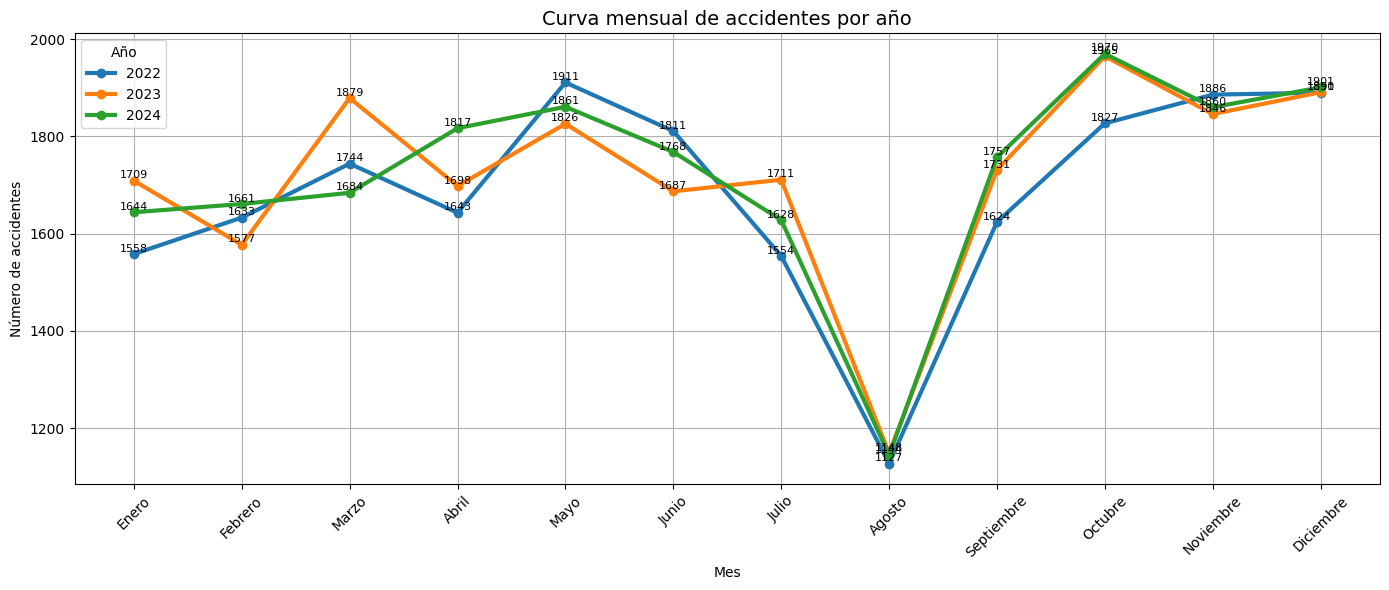

In [19]:
df_unicos = preparar_accidentes_unicos(df_accidentes)
curva_mensual_multianual(df_unicos)


In [38]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (1 fila = 1 accidente),
    agregados por num_expediente y con variables temporales derivadas.
    """

    df = df.copy()

    # Asegurar que fecha_hora es datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Limpiar tipo_accidente
    df['tipo_accidente_limpio'] = (
        df['tipo_accidente']
        .str.strip()
        .str.lower()
    )

    # Filtrar "no consta"
    df = df[df['tipo_accidente_limpio'] != "no consta"]

    # Agregación por accidente (1 fila = 1 expediente)
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente_limpio': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales derivadas
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos


#### Analisis univariante Geográfico

C:\Users\César\AppData\Local\Temp\ipykernel_13656\3678181170.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["distrito", df_all["fecha"].dt.year])["num_expediente"]


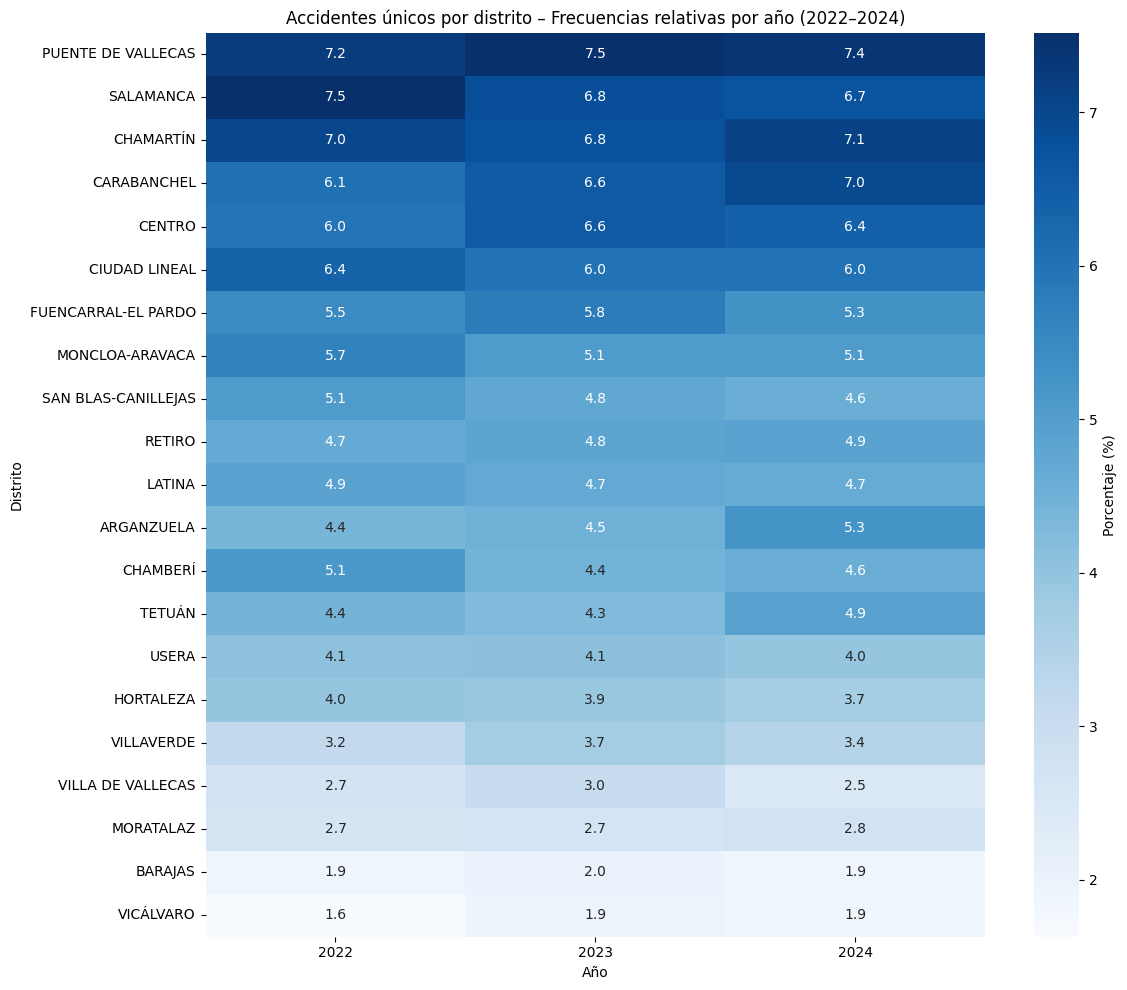

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Filtrar solo 2022–2024 ---
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

# --- 2. Calcular accidentes únicos por distrito y año ---
tabla = (
    df_all
    .groupby(["distrito", df_all["fecha"].dt.year])["num_expediente"]
    .nunique()
    .unstack(fill_value=0)
)

# --- 3. Convertir a porcentajes por año ---
tabla_pct = tabla.apply(lambda col: col / col.sum() * 100, axis=0)

# --- 4. Ordenar distritos por total de accidentes ---
tabla_pct = tabla_pct.loc[tabla.sum(axis=1).sort_values(ascending=False).index]

# --- 5. Heatmap con AÑOS en X y DISTRITOS en Y ---
plt.figure(figsize=(12, 10))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Porcentaje (%)"}
)

plt.title("Accidentes únicos por distrito – Frecuencias relativas por año (2022–2024)")
plt.xlabel("Año")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()


#### Analisis Univariante por tipo de accidente

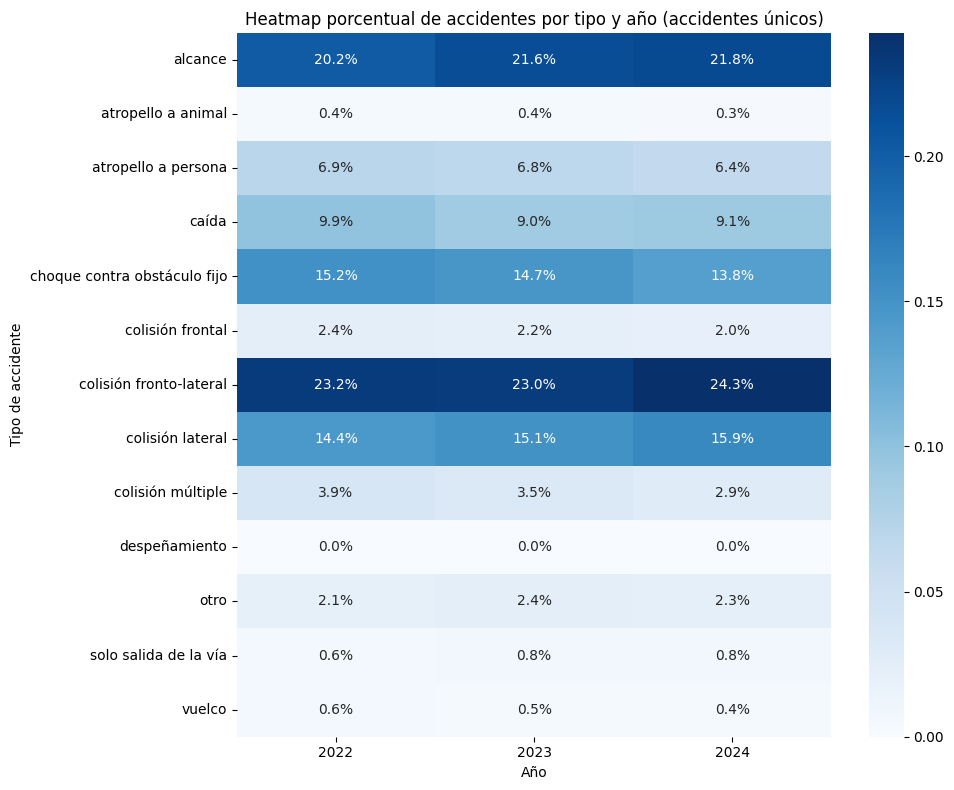

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar accidentes únicos
df_accidentes_unicos = preparar_accidentes_unicos(df_accidentes)

# 2. Filtrar años de interés
df_plot = df_accidentes_unicos[df_accidentes_unicos["año"].isin([2022, 2023, 2024])]

# 3. Tabla año × tipo_accidente (conteos)
tabla = (
    df_plot
    .pivot_table(
        index="tipo_accidente_limpio",
        columns="año",
        aggfunc="size",
        fill_value=0
    )
)

# 4. Convertir a porcentajes por año
tabla_pct = tabla.apply(lambda col: col / col.sum(), axis=0)

# 5. Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1%",
    cmap="Blues"
)

plt.title("Heatmap porcentual de accidentes por tipo y año (accidentes únicos)")
plt.xlabel("Año")
plt.ylabel("Tipo de accidente")
plt.tight_layout()
plt.show()


#### Analisdis Univariante por tipo de persona implicada en los accidente y por vehiculos

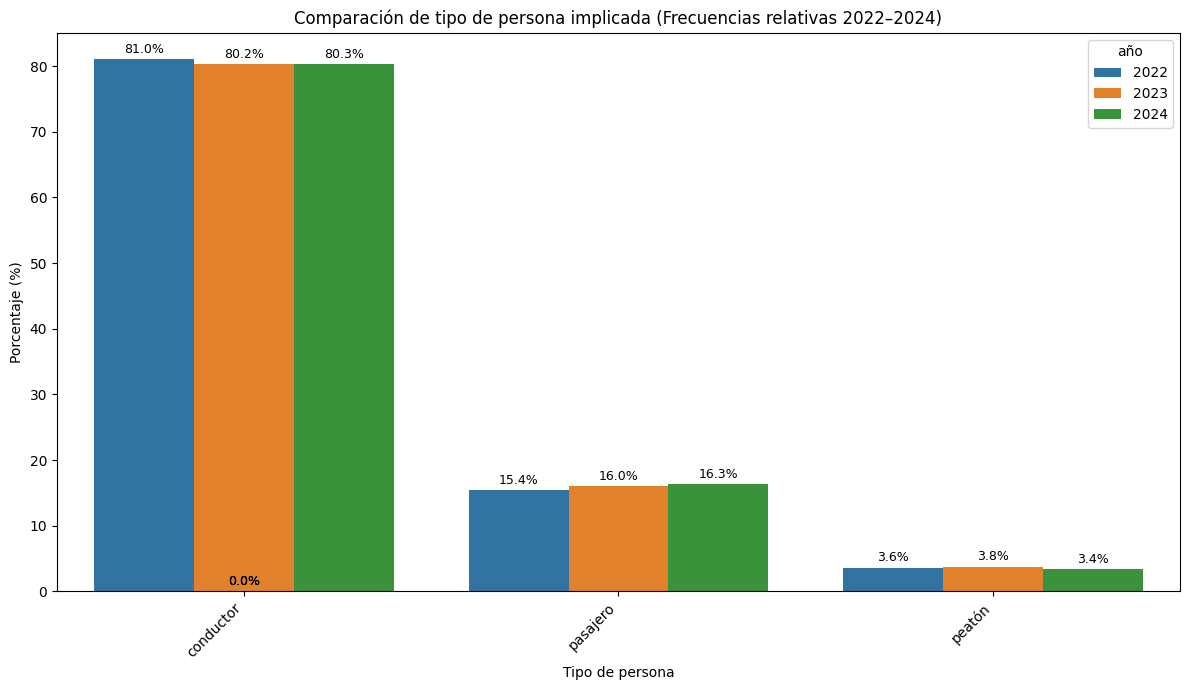

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Filtrar solo 2022–2024 ---
df_personas = df_accidentes[df_accidentes["fecha"].dt.year.isin([2022, 2023, 2024])]

# --- 2. Limpiar tipo_persona ---
df_personas["tipo_persona_limpio"] = (
    df_personas["tipo_persona"]
    .str.strip()
    .str.lower()
)

# --- 3. Frecuencias absolutas por año y tipo_persona ---
tabla = (
    df_personas
    .groupby(["año", "tipo_persona_limpio"])
    .size()
    .reset_index(name="n")
)

# --- 4. Calcular porcentajes por año ---
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# --- 5. Crear gráfico comparativo ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=tabla,
    x="tipo_persona_limpio",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Comparación de tipo de persona implicada (Frecuencias relativas 2022–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Tipo de persona")
plt.xticks(rotation=45, ha="right")

# --- 6. Añadir etiquetas encima de cada barra ---
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(
        x,
        height + 0.5,          # un pequeño margen encima de la barra
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


#### Analisis Univariante Demografico teniendo en cuenta los conductores

C:\Users\César\AppData\Local\Temp\ipykernel_13656\279139443.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["rango_edad", df_conductores["fecha"].dt.year])


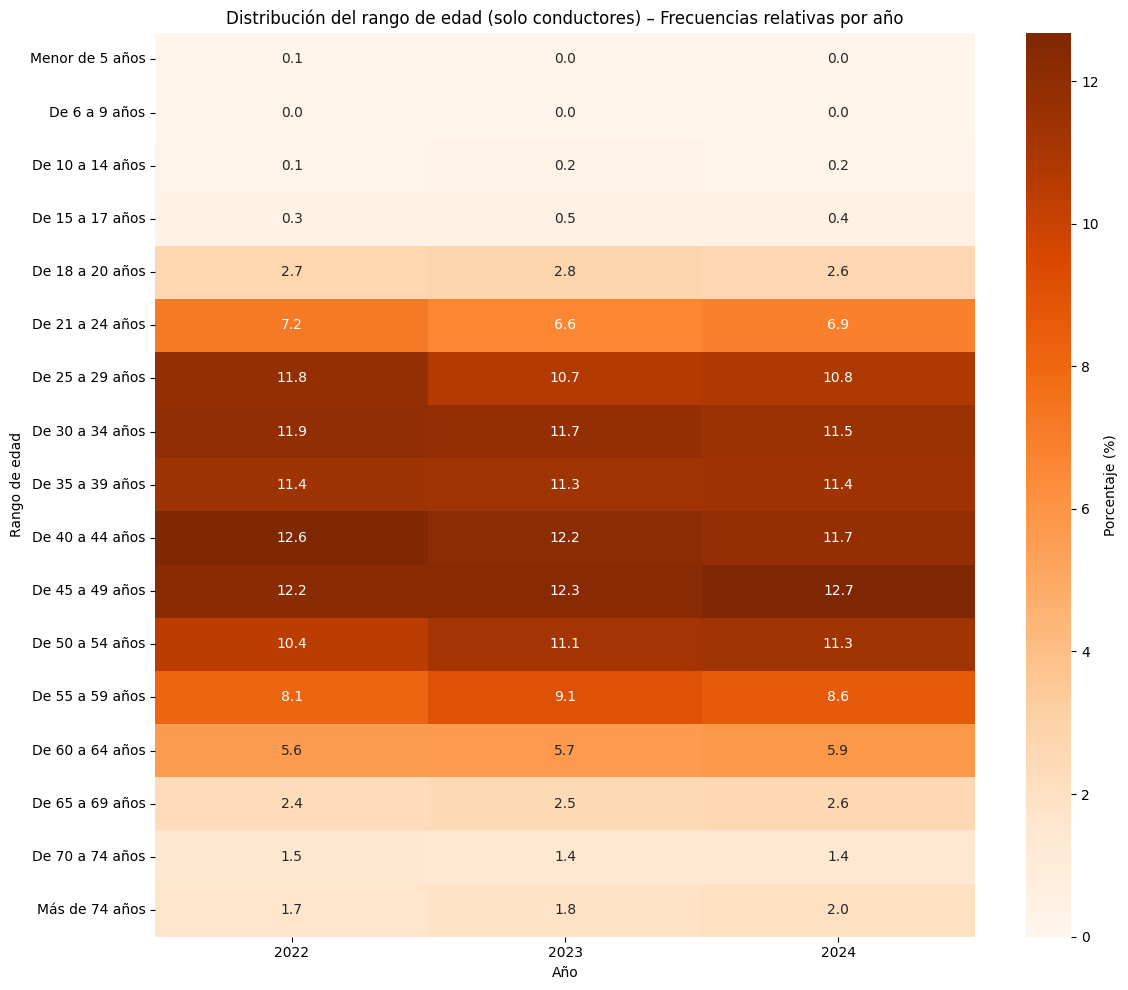

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Filtrar solo 2022–2024 ---
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

# --- 2. Filtrar solo conductores ---
df_conductores = df_all[
    df_all["tipo_persona"].str.strip().str.lower() == "conductor"
]

# --- 3. Eliminar "desconocido" ---
df_conductores = df_conductores[
    df_conductores["rango_edad"].str.strip().str.lower() != "desconocido"
]

# --- 4. Orden correcto de rangos de edad ---
orden_edad = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años",
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]

df_conductores["rango_edad"] = (
    df_conductores["rango_edad"]
    .str.strip()
    .astype("category")
    .cat.set_categories(orden_edad, ordered=True)
)

# --- 5. Crear tabla año × rango_edad ---
tabla = (
    df_conductores
    .groupby(["rango_edad", df_conductores["fecha"].dt.year])
    .size()
    .unstack(fill_value=0)
)

# --- 6. Convertir a porcentajes por año ---
tabla_pct = tabla.apply(lambda col: col / col.sum() * 100, axis=0)

# --- 7. Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Oranges",
    cbar_kws={"label": "Porcentaje (%)"}
)

plt.title("Distribución del rango de edad (solo conductores) – Frecuencias relativas por año")
plt.xlabel("Año")
plt.ylabel("Rango de edad")
plt.tight_layout()
plt.show()


C:\Users\César\AppData\Local\Temp\ipykernel_13656\1516114089.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["año", "sexo_limpio"])


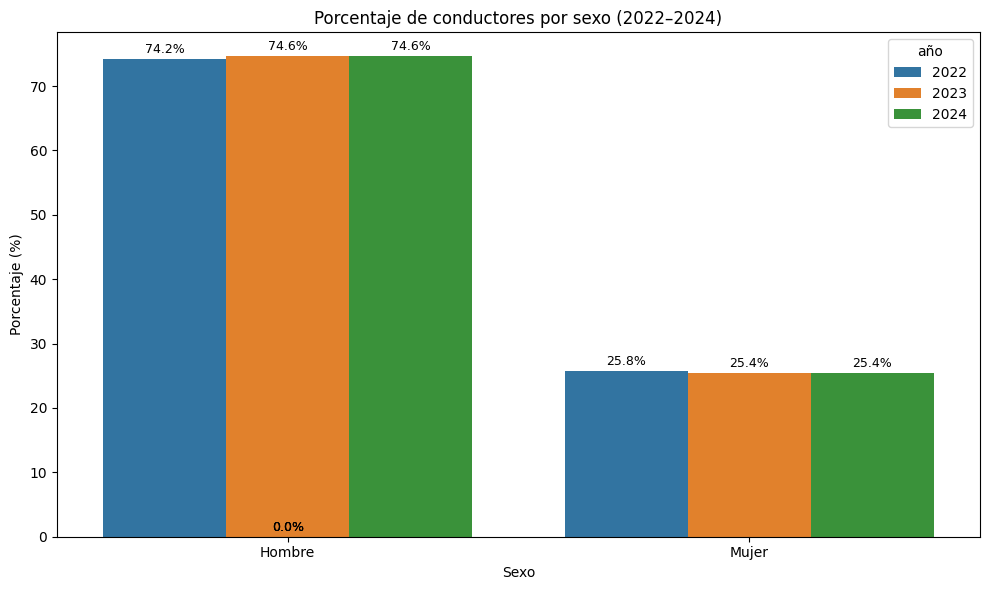

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Filtrar solo 2022–2024 ---
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

# --- 2. Filtrar solo conductores ---
df_conductores = df_all[
    df_all["tipo_persona"].str.strip().str.lower() == "conductor"
]

# --- 3. Eliminar "desconocido" ---
df_conductores = df_conductores[
    df_conductores["sexo"].str.strip().str.lower() != "desconocido"
]

# --- 4. Normalizar categorías ---
df_conductores["sexo_limpio"] = (
    df_conductores["sexo"]
    .str.strip()
    .str.capitalize()
)

orden_sexo = ["Hombre", "Mujer"]
df_conductores["sexo_limpio"] = (
    df_conductores["sexo_limpio"]
    .astype("category")
    .cat.set_categories(orden_sexo, ordered=True)
)

# --- 5. Frecuencias absolutas por año y sexo ---
tabla = (
    df_conductores
    .groupby(["año", "sexo_limpio"])
    .size()
    .reset_index(name="n")
)

# --- 6. Convertir a porcentajes por año ---
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# --- 7. Gráfico SOLO relativo ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=tabla,
    x="sexo_limpio",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Porcentaje de conductores por sexo (2022–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Sexo")
plt.xticks(rotation=0)

# --- 8. Etiquetas encima de cada barra ---
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(
        x,
        height + 0.5,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


#### Analisis de Lesividad 

C:\Users\César\AppData\Local\Temp\ipykernel_13656\1472116940.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["año", "lesividad_legible"])


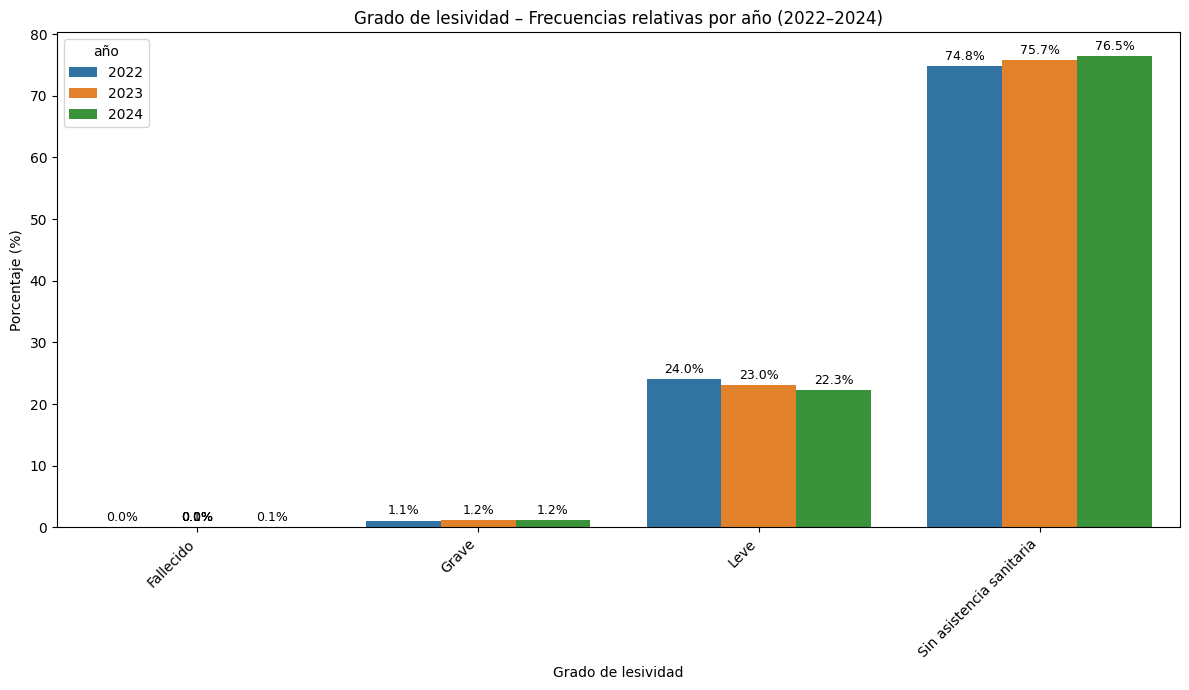

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re

# Función de limpieza profunda 
def limpiar_texto(x):
    x = str(x)
    x = unicodedata.normalize("NFKC", x)
    x = x.replace("\u00A0", " ")
    x = re.sub(r"\s+", " ", x)
    return x.strip().lower()

# 1. Filtrar solo 2022–2024 
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

# 2. Normalizar columna de lesividad 
df_all["lesividad_limpia"] = df_all["grado_lesividad"].apply(limpiar_texto)

# 3. Excluir "no consta" y "se desconoce" 
valores_excluir = ["no consta", "se desconoce"]
df_all = df_all[~df_all["lesividad_limpia"].isin(valores_excluir)]

# 4. Mapear nombres legibles 
etiquetas_legibles = {
    "sin asistencia sanitaria": "Sin asistencia sanitaria",
    "leve": "Leve",
    "grave": "Grave",
    "fallecido": "Fallecido"
}

df_all["lesividad_legible"] = df_all["lesividad_limpia"].map(
    lambda x: etiquetas_legibles.get(x, x.title())
)

# 5. Frecuencias absolutas por año y lesividad 
tabla = (
    df_all
    .groupby(["año", "lesividad_legible"])
    .size()
    .reset_index(name="n")
)

# 6. Convertir a porcentajes por año 
tabla["porcentaje"] = (
    tabla.groupby("año")["n"].transform(lambda x: x / x.sum() * 100)
)

# 6.1 Eliminar cualquier rastro de "se desconoce" 
tabla = tabla[~tabla["lesividad_legible"].str.lower().str.contains("desconoce")]

# 6.2 Convertir a string para eliminar categorías residuales 
tabla["lesividad_legible"] = tabla["lesividad_legible"].astype(str)

# 7. Gráfico SOLO relativo 
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=tabla,
    x="lesividad_legible",
    y="porcentaje",
    hue="año",
    palette="tab10"
)

plt.title("Grado de lesividad – Frecuencias relativas por año (2022–2024)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Grado de lesividad")
plt.xticks(rotation=45, ha="right")

# 8. Etiquetas encima de cada barra
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.text(
        x,
        height + 0.5,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


#### Analisis Univariante de Alcohol

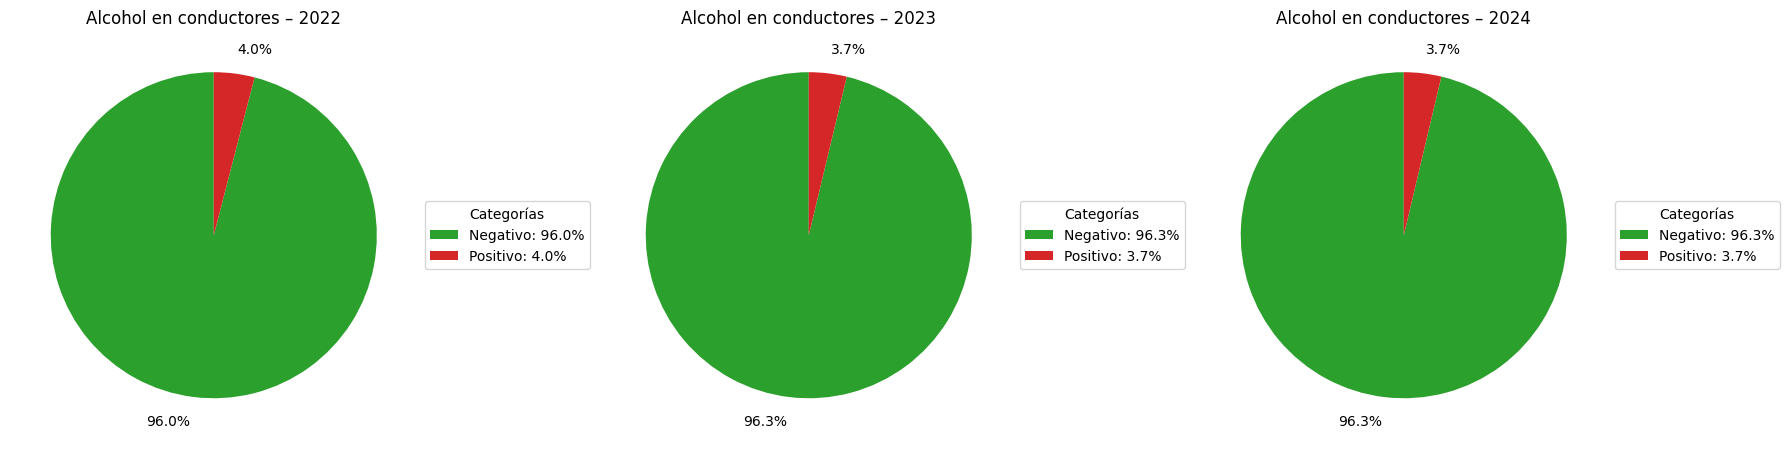

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Filtrar solo conductores de 2022–2024 ---
df_all = df_accidentes.copy()
df_all = df_all[df_all["fecha"].dt.year.isin([2022, 2023, 2024])]

df_conductores = df_all[
    df_all["tipo_persona"].str.lower().str.strip() == "conductor"
]

# --- 2. Normalizar columna de alcohol ---
alcohol_col = (
    df_conductores["positiva_alcohol"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# --- 3. Excluir "no consta" ---
alcohol_col = alcohol_col[alcohol_col != "no consta"]

# --- 4. Añadir columna limpia al dataframe ---
df_conductores = df_conductores.loc[alcohol_col.index].copy()
df_conductores["alcohol_limpio"] = alcohol_col

# --- 5. Paleta de colores personalizada ---
color_map = {
    "positivo": "#d62728",   # rojo
    "negativo": "#2ca02c",   # verde
}

# --- 6. Crear figura con 3 tartas (una por año) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, year in zip(axes, [2022, 2023, 2024]):

    df_year = df_conductores[df_conductores["fecha"].dt.year == year]

    # Frecuencias relativas
    rel_freq = df_year["alcohol_limpio"].value_counts(normalize=True) * 100

    # Colores en el orden correcto
    colors = [color_map.get(cat, "#999999") for cat in rel_freq.index]

    # Pie chart sin etiquetas internas
    wedges, _ = ax.pie(
        rel_freq,
        labels=None,
        autopct=None,
        startangle=90,
        colors=colors,
        radius=1
    )

    ax.set_title(f"Alcohol en conductores – {year}")

    # Etiquetas externas
    for wedge, pct in zip(wedges, rel_freq.values):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        label_x = 1.15 * x
        label_y = 1.15 * y
        ha = "left" if x > 0 else "right"
        ax.text(label_x, label_y, f"{pct:.1f}%", ha=ha, va="center", fontsize=10)

    # Leyenda
    legend_labels = [
        f"{cat.capitalize()}: {pct:.1f}%"
        for cat, pct in zip(rel_freq.index, rel_freq.values)
    ]

    ax.legend(
        wedges,
        legend_labels,
        title="Categorías",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

plt.tight_layout()
plt.show()
